# scANVI integration of disease dataset - fine grained annotations for myeloid cells

# Import and settings

In [1]:
%load_ext autoreload
%autoreload 2

import os, re, gc, joblib

import numpy as np
import numpy_groupies as npg
import scipy.sparse as sp
import pandas as pd
from sklearn.preprocessing import minmax_scale

import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import ListedColormap, LogNorm

import seaborn as sn

import anndata

import scanpy as sc
import sctk as sk

import torch
import scvi

Global seed set to 0


In [2]:
from collections import Counter
from sklearn.neighbors import KNeighborsTransformer

import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

In [3]:
rcParams["pdf.fonttype"] = 42
rcParams["ps.fonttype"] = 42
expr_cmap = sk.expression_colormap()
np.set_printoptions(linewidth=150)
sc.settings.verbosity = 0
sk.set_figsize((4, 4))
#torch.cuda.set_device(1)

#PYTHON = "/software/team205/miniconda3/envs/rapids-torch/bin/python"

#%cd ~/scratch/20220125_digestive_tract_integration/v2/

# Define functions

In [4]:
def weighted_knn_trainer(train_adata, train_adata_emb, label_key, n_neighbors=50):
    """Trains a weighted KNN classifier on ``train_adata``.
    Parameters
    ----------
    train_adata: :class:`~anndata.AnnData`
        Annotated dataset to be used to train KNN classifier with ``label_key`` as the target variable.
    train_adata_emb: str
        Name of the obsm layer to be used for calculation of neighbors. If set to "X", anndata.X will be
        used
    label_key: str
        Name of the column to be used as target variable (e.g. cell_type) in ``train_adata`` and ``query_adata``.
    n_neighbors: int
        Number of nearest neighbors in KNN classifier.
    """
    print(
        f"Weighted KNN with n_neighbors = {n_neighbors} ... ",
        end="",
    )
    k_neighbors_transformer = KNeighborsTransformer(
        n_neighbors=n_neighbors,
        mode="distance",
        algorithm="brute",
        metric="euclidean",
        n_jobs=-1,
    )
    if train_adata_emb == "X":
        train_emb = train_adata.X
    elif train_adata_emb in train_adata.obsm.keys():
        train_emb = train_adata.obsm[train_adata_emb]
    else:
        raise ValueError(
            "train_adata_emb should be set to either 'X' or the name of the obsm layer to be used!"
        )
    k_neighbors_transformer.fit(train_emb)
    return k_neighbors_transformer

In [5]:
def weighted_knn_transfer(
    query_adata,
    query_adata_emb,
    ref_adata_obs,
    label_keys,
    knn_model,
    threshold=1,
    pred_unknown=False,
    mode="package",
):
    """Annotates ``query_adata`` cells with an input trained weighted KNN classifier.
    Parameters
    ----------
    query_adata: :class:`~anndata.AnnData`
        Annotated dataset to be used to queryate KNN classifier. Embedding to be used
    query_adata_emb: str
        Name of the obsm layer to be used for label transfer. If set to "X",
        query_adata.X will be used
    ref_adata_obs: :class:`pd.DataFrame`
        obs of ref Anndata
    label_keys: str
        Names of the columns to be used as target variables (e.g. cell_type) in ``query_adata``.
    knn_model: :class:`~sklearn.neighbors._graph.KNeighborsTransformer`
        knn model trained on reference adata with weighted_knn_trainer function
    threshold: float
        Threshold of uncertainty used to annotating cells as "Unknown". cells with
        uncertainties higher than this value will be annotated as "Unknown".
        Set to 1 to keep all predictions. This enables one to later on play
        with thresholds.
    pred_unknown: bool
        ``False`` by default. Whether to annotate any cell as "unknown" or not.
        If `False`, ``threshold`` will not be used and each cell will be annotated
        with the label which is the most common in its ``n_neighbors`` nearest cells.
    mode: str
        Has to be one of "paper" or "package". If mode is set to "package",
        uncertainties will be 1 - P(pred_label), otherwise it will be 1 - P(true_label).
    """
    if not type(knn_model) == KNeighborsTransformer:
        raise ValueError(
            "knn_model should be of type sklearn.neighbors._graph.KNeighborsTransformer!"
        )

    if query_adata_emb == "X":
        query_emb = query_adata.X
    elif query_adata_emb in query_adata.obsm.keys():
        query_emb = query_adata.obsm[query_adata_emb]
    else:
        raise ValueError(
            "query_adata_emb should be set to either 'X' or the name of the obsm layer to be used!"
        )
    top_k_distances, top_k_indices = k_neighbors_transformer.kneighbors(X=query_emb)

    stds = np.std(top_k_distances, axis=1)
    stds = (2.0 / stds) ** 2
    stds = stds.reshape(-1, 1)

    top_k_distances_tilda = np.exp(-np.true_divide(top_k_distances, stds))

    weights = top_k_distances_tilda / np.sum(
        top_k_distances_tilda, axis=1, keepdims=True
    )
    cols = ref_adata_obs.columns[ref_adata_obs.columns.str.startswith(label_keys)]
    uncertainties = pd.DataFrame(columns=cols, index=query_adata.obs_names)
    pred_labels = pd.DataFrame(columns=cols, index=query_adata.obs_names)
    for i in range(len(weights)):
        for j in cols:
            y_train_labels = ref_adata_obs[j].values
            unique_labels = np.unique(y_train_labels[top_k_indices[i]])
            best_label, best_prob = None, 0.0
            for candidate_label in unique_labels:
                candidate_prob = weights[
                    i, y_train_labels[top_k_indices[i]] == candidate_label
                ].sum()
                if best_prob < candidate_prob:
                    best_prob = candidate_prob
                    best_label = candidate_label

            if pred_unknown:
                if best_prob >= threshold:
                    pred_label = best_label
                else:
                    pred_label = "Unknown"
            else:
                pred_label = best_label

            if mode == "package":
                uncertainties.iloc[i][j] = (max(1 - best_prob, 0))

            else:
                raise Exception("Inquery Mode!")

            pred_labels.iloc[i][j] = (pred_label)

    print("finished!")

    return pred_labels, uncertainties

# 1. Predict fine grained level on full epithelial object

## Load data

In [6]:
adata = sc.read_h5ad('/home/jupyter/Annotations_v3/pre_scvi20221124_updated_donorID_20230126/with_doublets/pooled_healthy.lv20_batch256.with_broad_annotation.20220917.with_countlayers.20221124.Myeloid.20230126.h5ad')

In [7]:
ad_output = sc.read_h5ad('/home/jupyter/Annotations_v3/scvi_output20230126/Myeloid.hvg5000_noCC.scvi_output.20230126-ad1.h5ad')

In [8]:
adata

AnnData object with n_obs × n_vars = 37393 × 36601
    obs: 'latent_cell_probability', 'latent_RT_efficiency', 'cecilia22_predH', 'cecilia22_predH_prob', 'cecilia22_predH_uncertain', 'cecilia22_predL', 'cecilia22_predL_prob', 'cecilia22_predL_uncertain', 'elmentaite21_pred', 'elmentaite21_pred_prob', 'elmentaite21_pred_uncertain', 'suo22_pred', 'suo22_pred_prob', 'suo22_pred_uncertain', 'n_counts', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50', 'n_counts_raw', 'log1p_n_counts_raw', 'n_genes_raw', 'log1p_n_genes_raw', 'percent_mito_raw', 'n_counts_mito_raw', 'percent_ribo_raw', 'n_counts_ribo_raw', 'percent_hb_raw', 'n_counts_hb_raw', 'percent_top50_raw', 'n_counts_spliced', 'log1p_n_counts_spliced', 'n_genes_spliced', 'log1p_n_genes_spliced', 'percent_mito_spliced', 'n_counts_mito_spliced', 'percent_ribo_spliced', 'n_counts_ribo_spliced', 'percent_hb_spliced', 'n_counts_hb_spl

In [9]:
ad_output

AnnData object with n_obs × n_vars = 37393 × 4736
    obs: 'latent_cell_probability', 'latent_RT_efficiency', 'cecilia22_predH', 'cecilia22_predH_prob', 'cecilia22_predH_uncertain', 'cecilia22_predL', 'cecilia22_predL_prob', 'cecilia22_predL_uncertain', 'elmentaite21_pred', 'elmentaite21_pred_prob', 'elmentaite21_pred_uncertain', 'suo22_pred', 'suo22_pred_prob', 'suo22_pred_uncertain', 'n_counts', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50', 'n_counts_raw', 'log1p_n_counts_raw', 'n_genes_raw', 'log1p_n_genes_raw', 'percent_mito_raw', 'n_counts_mito_raw', 'percent_ribo_raw', 'n_counts_ribo_raw', 'percent_hb_raw', 'n_counts_hb_raw', 'percent_top50_raw', 'n_counts_spliced', 'log1p_n_counts_spliced', 'n_genes_spliced', 'log1p_n_genes_spliced', 'percent_mito_spliced', 'n_counts_mito_spliced', 'percent_ribo_spliced', 'n_counts_ribo_spliced', 'percent_hb_spliced', 'n_counts_hb_spli

In [10]:
adata.obs.fine_annot.value_counts()

Macrophage                8594
DC_cDC2                   6381
Mast                      5607
Doublets                  4180
Monocyte                  3792
Macrophage_LYVE1          3627
Macrophage_TREM2          1511
DC_cDC1                    946
Macrophage_MMP9            907
DC_pDC                     565
DC_migratory               417
Erythrocytes               350
Mono/neutrophil_MPO        178
DC_langerhans              164
Macrophage_CD5L            100
Eosinophil/basophil         70
Megakaryocyte/platelet       4
Name: fine_annot, dtype: int64

In [11]:
adata = adata[:, adata.var_names.isin(ad_output.var_names)].copy()

In [12]:
adata

AnnData object with n_obs × n_vars = 37393 × 4736
    obs: 'latent_cell_probability', 'latent_RT_efficiency', 'cecilia22_predH', 'cecilia22_predH_prob', 'cecilia22_predH_uncertain', 'cecilia22_predL', 'cecilia22_predL_prob', 'cecilia22_predL_uncertain', 'elmentaite21_pred', 'elmentaite21_pred_prob', 'elmentaite21_pred_uncertain', 'suo22_pred', 'suo22_pred_prob', 'suo22_pred_uncertain', 'n_counts', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50', 'n_counts_raw', 'log1p_n_counts_raw', 'n_genes_raw', 'log1p_n_genes_raw', 'percent_mito_raw', 'n_counts_mito_raw', 'percent_ribo_raw', 'n_counts_ribo_raw', 'percent_hb_raw', 'n_counts_hb_raw', 'percent_top50_raw', 'n_counts_spliced', 'log1p_n_counts_spliced', 'n_genes_spliced', 'log1p_n_genes_spliced', 'percent_mito_spliced', 'n_counts_mito_spliced', 'percent_ribo_spliced', 'n_counts_ribo_spliced', 'percent_hb_spliced', 'n_counts_hb_spli

In [13]:
#load reference that was run without study as a categorical co-variate
scvi_ref = scvi.model.SCVI.load("/home/jupyter/Annotations_v3/scvi_output20230126/Myeloid.hvg5000_noCC.scvi_output.20230126.vae",adata)

INFO     File /home/jupyter/Annotations_v3/scvi_output20230126/Myeloid.hvg5000_noCC.scvi_outp
         ut.20230126.vae/model.pt already downloaded                                         


/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/data/_utils.py:156: UserWarning: Category 28 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  warnings.warn(


# Process

## Train

In [21]:
scanvi_ref.adata

AnnData object with n_obs × n_vars = 37393 × 4736
    obs: 'latent_cell_probability', 'latent_RT_efficiency', 'cecilia22_predH', 'cecilia22_predH_prob', 'cecilia22_predH_uncertain', 'cecilia22_predL', 'cecilia22_predL_prob', 'cecilia22_predL_uncertain', 'elmentaite21_pred', 'elmentaite21_pred_prob', 'elmentaite21_pred_uncertain', 'suo22_pred', 'suo22_pred_prob', 'suo22_pred_uncertain', 'n_counts', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50', 'n_counts_raw', 'log1p_n_counts_raw', 'n_genes_raw', 'log1p_n_genes_raw', 'percent_mito_raw', 'n_counts_mito_raw', 'percent_ribo_raw', 'n_counts_ribo_raw', 'percent_hb_raw', 'n_counts_hb_raw', 'percent_top50_raw', 'n_counts_spliced', 'log1p_n_counts_spliced', 'n_genes_spliced', 'log1p_n_genes_spliced', 'percent_mito_spliced', 'n_counts_mito_spliced', 'percent_ribo_spliced', 'n_counts_ribo_spliced', 'percent_hb_spliced', 'n_counts_hb_spli

In [14]:
x_scanvi = pd.read_csv(
    "/home/jupyter/Annotations_v3/models/scanvi_compartments/Myeloid_hvg5000.noCC_scvi.scanvi_fine_annot.20230226.csv.gz",compression='gzip',index_col=0)

In [15]:
x_scanvi

,LV1,LV2,LV3,LV4,LV5,LV6,LV7,LV8,LV9,LV10,LV11,LV12,LV13,LV14,LV15,LV16,LV17,LV18,LV19,LV20
index,,,,,,,,,,,,,,,,,,,,
AAACGCTAGCGACCCT-GSM4600896,-0.029375,0.598412,0.074087,-0.137727,1.263821,0.124621,-0.035878,0.288551,1.095610,-0.144275,-0.017269,-1.828688,0.023520,-0.101623,0.065990,1.976230,-0.711546,0.730882,0.287919,0.056095
AAAGGGCAGTCACACT-GSM4600896,-0.036976,0.498846,0.082328,-0.121302,2.019891,0.137434,-0.032392,-0.203248,1.343846,-0.196210,-0.028496,-1.695960,-0.007679,-0.124085,0.055898,0.734803,0.281928,0.510984,0.403333,0.009518
AAAGGGCCAACACAGG-GSM4600896,-0.222939,-0.784251,0.012773,-0.253297,0.447109,-3.342697,-0.071255,-0.046597,-1.190531,-0.182178,0.075084,-1.371584,0.085910,-0.212031,-0.038512,-1.133625,1.070159,0.103679,1.218980,0.616137
AAAGTCCGTCGAAGCA-GSM4600896,-0.040166,0.208586,0.075654,-0.118172,1.361113,0.257864,-0.036177,-0.090816,0.782147,-0.080299,-0.010892,-2.149660,0.002015,-0.057738,-0.005992,0.889079,-0.800602,0.486683,-0.233410,0.441300
AAAGTGACACCCATAA-GSM4600896,-0.086671,0.774538,0.042071,-0.076656,1.404197,0.399673,-0.038933,-1.371565,0.500224,-0.060172,-0.042539,-2.294494,-0.002884,0.001888,-0.009952,1.053782,-0.709229,-0.161011,-0.594445,0.316283
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCTTTCCTCCTGCAGG-GSM5525958,-0.042964,-1.354237,-0.037096,-0.068821,0.841769,0.887550,0.027339,-0.705557,0.050462,-0.046727,0.007477,-0.011443,0.068615,0.121413,-0.032975,-0.932305,-0.043650,-0.076635,-0.224351,-0.324805
TGAGCCGTCTTGAGGT-GSM5525958,-0.005315,-0.838935,0.008191,-0.066718,-0.206473,-0.274866,-0.003288,-1.118631,0.522161,0.002127,-0.011243,0.968082,0.040222,0.068800,0.090801,0.803508,-0.662949,-0.977344,-0.179212,0.064305
TGGCTGGCAATACGCT-GSM5525958,-0.059708,-0.009673,0.062703,-0.111497,-0.826880,-1.385922,-0.059768,-1.405210,0.603722,0.183278,0.082135,0.210807,-0.000286,0.042226,0.091518,-0.131342,-0.263850,0.614054,-1.214533,0.430498


In [16]:
adata.obsm['X_scANVI'] = x_scanvi

## Query

In [17]:
disease_ad = sc.read('/home/jupyter/neutrophils/pooled_healthy.gene_cellbender.bad_qc_cluster_mito80.neutrophil.20221013.h5ad')

In [18]:
disease_ad

AnnData object with n_obs × n_vars = 1893 × 36601
    obs: 'latent_cell_probability', 'latent_RT_efficiency', 'cecilia22_predH', 'cecilia22_predH_prob', 'cecilia22_predH_uncertain', 'cecilia22_predL', 'cecilia22_predL_prob', 'cecilia22_predL_uncertain', 'elmentaite21_pred', 'elmentaite21_pred_prob', 'elmentaite21_pred_uncertain', 'suo22_pred', 'suo22_pred_prob', 'suo22_pred_uncertain', 'n_counts', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50', 'n_counts_raw', 'log1p_n_counts_raw', 'n_genes_raw', 'log1p_n_genes_raw', 'percent_mito_raw', 'n_counts_mito_raw', 'percent_ribo_raw', 'n_counts_ribo_raw', 'percent_hb_raw', 'n_counts_hb_raw', 'percent_top50_raw', 'n_counts_spliced', 'log1p_n_counts_spliced', 'n_genes_spliced', 'log1p_n_genes_spliced', 'percent_mito_spliced', 'n_counts_mito_spliced', 'percent_ribo_spliced', 'n_counts_ribo_spliced', 'percent_hb_spliced', 'n_counts_hb_spli

In [19]:
disease_ad = disease_ad[:, disease_ad.var_names.isin(ad_output.var_names)].copy()

In [20]:
disease_ad

AnnData object with n_obs × n_vars = 1893 × 4736
    obs: 'latent_cell_probability', 'latent_RT_efficiency', 'cecilia22_predH', 'cecilia22_predH_prob', 'cecilia22_predH_uncertain', 'cecilia22_predL', 'cecilia22_predL_prob', 'cecilia22_predL_uncertain', 'elmentaite21_pred', 'elmentaite21_pred_prob', 'elmentaite21_pred_uncertain', 'suo22_pred', 'suo22_pred_prob', 'suo22_pred_uncertain', 'n_counts', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50', 'n_counts_raw', 'log1p_n_counts_raw', 'n_genes_raw', 'log1p_n_genes_raw', 'percent_mito_raw', 'n_counts_mito_raw', 'percent_ribo_raw', 'n_counts_ribo_raw', 'percent_hb_raw', 'n_counts_hb_raw', 'percent_top50_raw', 'n_counts_spliced', 'log1p_n_counts_spliced', 'n_genes_spliced', 'log1p_n_genes_spliced', 'percent_mito_spliced', 'n_counts_mito_spliced', 'percent_ribo_spliced', 'n_counts_ribo_spliced', 'percent_hb_spliced', 'n_counts_hb_splic

In [21]:
scanvi_query = scvi.model.SCANVI.load_query_data(
    disease_ad,
    "/home/jupyter/Annotations_v3/models/scanvi_compartments/Myeloid_hvg5000.noCC_scvi.scanvi_fine_annot.20230226/model.pt",
)

INFO     File /home/jupyter/Annotations_v3/models/scanvi_compartments/Myeloid_hvg5000.noCC_sc
         vi.scanvi_fine_annot.20230226/model.pt/model.pt already downloaded                  


/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/data/fields/_scanvi.py:89: UserWarning: Missing labels key fine_annot. Filling in with unlabeled category Unknown.
  warnings.warn(


In [22]:
scanvi_query.train(
    max_epochs=100, plan_kwargs=dict(weight_decay=0.0), check_val_every_n_epoch=10
)

INFO     Training for 100 epochs.                                                            


/opt/conda/envs/scvi/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (ElboMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/100:   0%|          | 0/100 [00:00<?, ?it/s]

/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:61: UserWarning: Specified kernel cache directory could not be created! This disables kernel caching. Specified directory is /home/jupyter/.cache/torch/kernels. This warning will appear only once per process. (Triggered internally at  ../aten/src/ATen/native/cuda/jit_utils.cpp:860.)
  + torch.lgamma(x + theta)


Epoch 100/100: 100%|██████████| 100/100 [00:23<00:00,  4.20it/s, loss=378, v_num=1]


In [23]:
scanvi_query.save(
    "/home/jupyter/Annotations_v3/neutrophils/Myeloid_neutrophils.scanvi_fine_annot_vae.20231205/model.pt"
)

In [24]:
disease_ad.obsm["X_scANVI"] = scanvi_query.get_latent_representation()

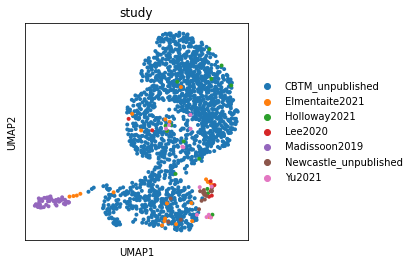

In [27]:
sc.pp.neighbors(disease_ad, use_rep="X_scANVI")
sc.tl.umap(disease_ad)
sc.pl.umap(disease_ad, color=['study'])

In [29]:
adata

AnnData object with n_obs × n_vars = 37393 × 4736
    obs: 'latent_cell_probability', 'latent_RT_efficiency', 'cecilia22_predH', 'cecilia22_predH_prob', 'cecilia22_predH_uncertain', 'cecilia22_predL', 'cecilia22_predL_prob', 'cecilia22_predL_uncertain', 'elmentaite21_pred', 'elmentaite21_pred_prob', 'elmentaite21_pred_uncertain', 'suo22_pred', 'suo22_pred_prob', 'suo22_pred_uncertain', 'n_counts', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50', 'n_counts_raw', 'log1p_n_counts_raw', 'n_genes_raw', 'log1p_n_genes_raw', 'percent_mito_raw', 'n_counts_mito_raw', 'percent_ribo_raw', 'n_counts_ribo_raw', 'percent_hb_raw', 'n_counts_hb_raw', 'percent_top50_raw', 'n_counts_spliced', 'log1p_n_counts_spliced', 'n_genes_spliced', 'log1p_n_genes_spliced', 'percent_mito_spliced', 'n_counts_mito_spliced', 'percent_ribo_spliced', 'n_counts_ribo_spliced', 'percent_hb_spliced', 'n_counts_hb_spli

In [30]:
k_neighbors_transformer = weighted_knn_trainer(
        train_adata=adata,
        train_adata_emb="X_scANVI",
        label_key="fine_annot",
        n_neighbors=50,
    )

Weighted KNN with n_neighbors = 50 ... 

In [31]:
k_neighbors_transformer

KNeighborsTransformer(algorithm='brute', metric='euclidean', n_jobs=-1,
                      n_neighbors=50)

In [33]:
labels, uncert = weighted_knn_transfer(
        query_adata=disease_ad,
        query_adata_emb="X_scANVI",
        label_keys="fine_annot",
        knn_model=k_neighbors_transformer,
        ref_adata_obs = adata.obs
    )

/opt/conda/envs/scvi/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsTransformer was fitted with feature names
  warnings.warn(


finished!


In [34]:
labels

,fine_annot
index,
AAACCTGCAACTGCGC-HCA_A_GT12934997,Monocyte
AAACCTGCATGGTAGG-HCA_A_GT12934997,Monocyte
AAAGATGAGGACAGCT-HCA_A_GT12934997,Monocyte
AAAGTAGTCAACGAAA-HCA_A_GT12934997,Monocyte
AACACGTAGAGACTAT-HCA_A_GT12934997,Monocyte
...,...
CTACATTGTCTGCCAG-HT228-fetal-ileum,Mono/neutrophil_MPO
CTCGTCATCACCTTAT-HT228-fetal-ileum,Mono/neutrophil_MPO
TGACAACAGAAGGGTA-HT228-fetal-ileum,Monocyte


In [35]:
uncert

,fine_annot
index,
AAACCTGCAACTGCGC-HCA_A_GT12934997,0.099994
AAACCTGCATGGTAGG-HCA_A_GT12934997,0.03999
AAAGATGAGGACAGCT-HCA_A_GT12934997,0.080006
AAAGTAGTCAACGAAA-HCA_A_GT12934997,0.059993
AACACGTAGAGACTAT-HCA_A_GT12934997,0.02
...,...
CTACATTGTCTGCCAG-HT228-fetal-ileum,0.29961
CTCGTCATCACCTTAT-HT228-fetal-ileum,0.339713
TGACAACAGAAGGGTA-HT228-fetal-ileum,0


In [36]:
disease_ad.obs['fine_predicted_labels'] = labels['fine_annot']
disease_ad.obs['fine_predicted_labels_uncertainty'] = uncert['fine_annot']

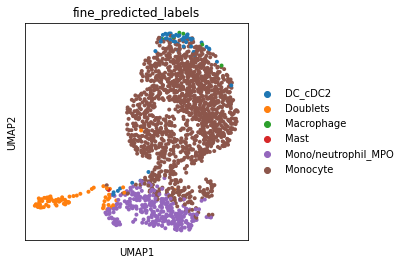

In [37]:
sc.pl.umap(disease_ad, color=['fine_predicted_labels'])

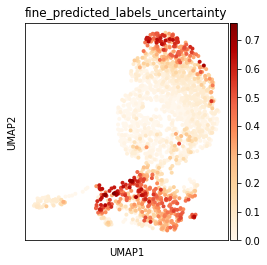

In [38]:
sc.pl.umap(disease_ad, color=['fine_predicted_labels_uncertainty'],cmap='OrRd')

In [39]:
disease_ad.obs["scanvi_pred"] = scanvi_query.predict(disease_ad)

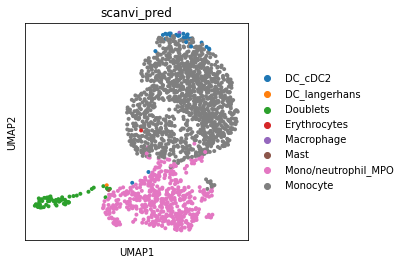

In [40]:
sc.pl.umap(disease_ad, color=['scanvi_pred'])

In [41]:
pd.DataFrame(
    disease_ad.obsm["X_scANVI"],
    index=disease_ad.obs_names,
    columns=[f"LV{i+1}" for i in range(disease_ad.obsm["X_scANVI"].shape[1])],
).to_csv(
    "/home/jupyter/neutrophils/neutrophils_fine_annot_predict_Myeloid_20231205.csv.gz"
)

In [42]:
disease_ad.obs.to_csv('/home/jupyter/neutrophils/neutrophils_fine_annot_predict_Myeloid_20231205_meta.csv')